In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


## Fashion MNIST

In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [17]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

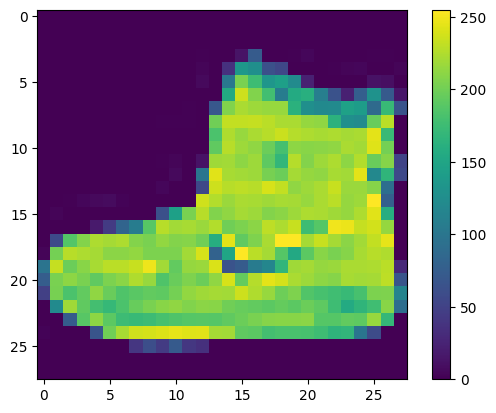

In [18]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [19]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

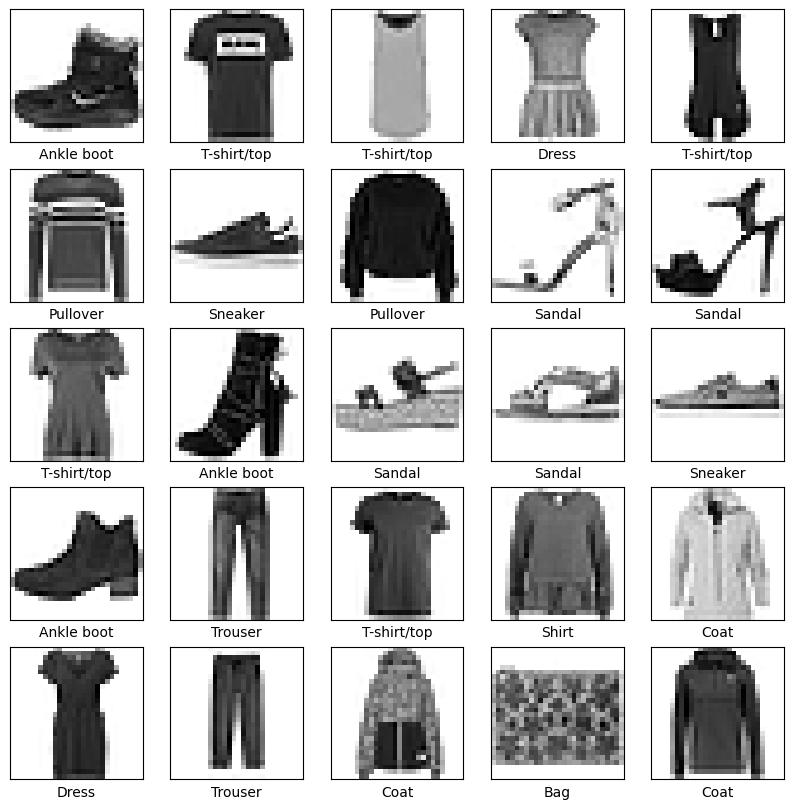

In [20]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [21]:
batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

In [22]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.LSTM(64, name='LSTM_left')(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
x2 = tf.keras.layers.LSTM(64, name='LSTM_right')(x2)

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 28, 28)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 28, 64)    │      5,440 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 28, 64)    │      5,440 │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 28, 64)    │     12,352 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 28, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 28, 128)   │     66,048 │ conv1d_5[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 28, 128)   │     66,048 │ conv1d_7[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_left (LSTM)    │ (None, 64)        │     49,408 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_right (LSTM)   │ (None, 64)        │     49,408 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ LSTM_left[0][0],  │
│ (Concatenate)       │                   │            │ LSTM_right[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,786 (1.02 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=2, batch_size=batch_size)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 47ms/step - accuracy: 0.7263 - loss: 0.7377
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - accuracy: 0.8573 - loss: 0.3906


In [24]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

original_weights_right = model_fashion_lstm.get_layer('LSTM_right').get_weights()
original_weights_left = model_fashion_lstm.get_layer('LSTM_left').get_weights()

In [25]:
test_loss, test_acc = model_fashion_lstm.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 3s - 8ms/step - accuracy: 0.8713 - loss: 0.3521

Test accuracy: 0.8712999820709229


In [ ]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'model/Fashion_LSTM___Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_acc}.keras'

# Save the Model.
model_fashion_lstm.save(model_file_name)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
0.8713


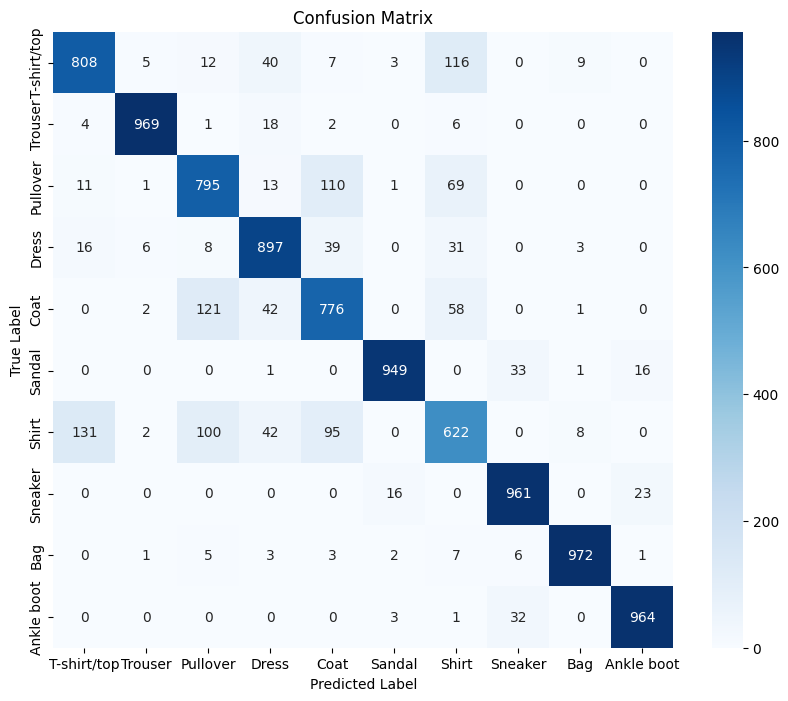

In [26]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/main')
from iterative_approximation.Algorithm1 import *

import statistics

import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [32]:
def save_layer_weights(layer, file_path):
    """
    Save the weights of a specific layer to a NumPy .npz file.
    
    Parameters:
        layer: The layer of which weights are to be saved.
        file_path: Path to save the file.
    """
    # Get weights from the layer (list of numpy arrays)
    weights = layer.get_weights()
    # Save each weight array individually within the .npz file
    np.savez(file_path, **{f'arr_{i}': w for i, w in enumerate(weights)})

def load_layer_weights(layer, file_path):
    """
    Load weights from a NumPy .npz file into a specified layer.
    
    Parameters:
        layer: The layer to which weights are to be loaded.
        file_path: Path from where to load the file.
    """
    # Load the .npz file
    data = np.load(file_path, allow_pickle=True)
    # Extract weights in the order they were saved
    weights = [data[f'arr_{i}'] for i in range(len(data.files))]
    # Set the weights to the layer
    layer.set_weights(weights)

In [30]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


0.8713

In [33]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

save_layer_weights(LSTM_right_layer, 'LSTM_right_layer_weights.npz')
save_layer_weights(LSTM_left_layer, 'LSTM_left_layer_weights.npz')

In [ ]:
load_layer_weights(LSTM_right_layer, 'LSTM_right_layer_weights.npz')
load_layer_weights(LSTM_left_layer, 'LSTM_left_layer_weights.npz')

In [21]:
def evaluation1(weight_array):
    W = WeightArray(weight_array)
    Nsteps = range(1, 20)

    MSE_values = {}  # Dictionary to hold MSE values for different thresholds
    threshold_list = [0.0001, 0.001, 0.01]

    for threshold in threshold_list:
        MSE_values[threshold] = []  # Initialize an empty list for each threshold
        for Nstep in Nsteps:
            # Your function to get a reconstructed matrix
            reconstructed = W.iterative_approximation_step(Nstep, threshold)
            # Your function to calculate MSE
            MSE = mean_square_error_array(reconstructed, weight_array)
            MSE_values[threshold].append(np.mean(MSE))  # Store the average MSE for this threshold and Nstep

    # Plotting
    plt.figure(figsize=(10, 6))
    for threshold, mse_list in MSE_values.items():
        plt.plot(Nsteps, mse_list, label=f'Threshold = {threshold:.5f}')

    plt.xlabel('Nstep')
    plt.ylabel('Mean Squared Error')
    plt.yscale('log')
    plt.title('Average MSE vs Nstep for Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluation2(weight_array, yscale='normal'):
    W = WeightArray(weight_array)
    Nsteps = range(1, 50)

    MSE_values = []  # List to hold MSE values for different Nsteps
    compression_ratio = []  # List to hold compression ratios for different Nsteps

    threshold = 0.0001

    for Nstep in Nsteps:
        # Your function to get a reconstructed matrix
        reconstructed = W.iterative_approximation_step(Nstep, threshold)
        # Your function to calculate MSE
        MSE = mean_square_error_array(reconstructed, weight_array)
        MSE_values.append(MSE)  # Store the MSE for this Nstep
        compression_ratio.append(W.compression_ratio())  # Store the compression ratio for this Nstep

    # Creating a figure to hold both subplots
    plt.figure(figsize=(20, 6))

    # Subplot 1: MSE vs Nstep
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    colors = plt.cm.viridis(np.linspace(0, 1, len(weight_array)))
    for idx, weight in enumerate(weight_array):
        # Extract the MSE series for the current weight across all Nsteps
        mse_series = [MSE_values[step][idx] for step in range(len(Nsteps))]
        plt.plot(Nsteps, mse_series, color=colors[idx], label=f'Weight {idx + 1}')

    plt.xlabel('Nstep')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE vs Nstep for Different Weights')
    if yscale == 'log':
        plt.yscale('log')
        plt.title('MSE vs Nstep for Different Weights (Log Scale)')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Compression Ratio vs Nstep
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(Nsteps, compression_ratio, label='Compression Ratio', color='blue')
    plt.xlabel('Nstep')
    plt.ylabel('Compression Ratio')
    plt.title('Compression Ratio vs Nstep')
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline Compression Ratio')  
    plt.grid(True)

    plt.show()

def evaluation3(weight_array):
    W1 = WeightArray(weight_array)

    W2 = Weight()
    weight = np.vstack([w for w in weight_array])
    W2.init_weight(weight)

    threshold = 0.0001

    MSE_list = np.linspace(0.001,0.05,50)
    compression_ratio1 = []
    compression_ratio2 = []

    for MSE in MSE_list:
        reconstructed = W1.iterative_approximation(MSE, 500, threshold)
        compression_ratio1.append(W1.compression_ratio())

        reconstructed = W2.iterative_approximation(MSE, 41, 500, 1, 1)
        compression_ratio2.append(W2.compression_ratio())

    # Now, plot the compression ratio against MSE
    plt.figure(figsize=(10, 6))
    plt.plot(MSE_list, compression_ratio1, marker='o', linestyle='-', color='blue', label='Algorithm 2 Compression Ratio')
    plt.plot(MSE_list, compression_ratio2, marker='o', linestyle='-', color='orange', label='Algorithm 1 Compression Ratio')
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline Compression Ratio')  
    plt.xlabel('Mean Squared Error (MSE)')
    plt.ylabel('Compression Ratio')
    plt.title('Compression Ratio vs. MSE')
    plt.grid(True)
    plt.legend()
    plt.show()

def evaluation4(weight_array):
    matrix_idx_list = [0,1,2,3]
    threshold = 0.0001
    MSE_list = np.linspace(0.001,0.05,50)
    groupings = generate_groupings(matrix_idx_list)
    colors = cm.viridis(np.linspace(0, 1, len(groupings)))
    fig, ax = plt.subplots()
    for idx, group in enumerate(groupings): 
        average_compression_ratio = []
        for MSE in MSE_list:
            compression_ratio = []
            for subset in group:
                weight = [weight_array[i] for i in subset]
                W = WeightArray(weight)  
                W.iterative_approximation(MSE, 500, threshold) 
                compression_ratio.append(W.compression_ratio())
            average_compression_ratio.append(np.mean(compression_ratio))
        
        # Plotting with a unique color and a label indicating the grouping
        ax.plot(MSE_list, average_compression_ratio, marker='o', linestyle='-', color=colors[idx], label='Grouping ' + str(group))

    ax.set_xlabel('MSE')  # Set X-axis label
    ax.set_ylabel('Average Compression Ratio')  # Set Y-axis label
    ax.set_title('Compression Ratios for Different Groupings')  # Set title
    ax.legend(loc='best', fontsize='small', title="Groupings")  # Add a legend with a title
    plt.show()

def evaluation5(weight_array,step):
    matrix_idx_list = [0,1,2,3]
    threshold = 0.0001
    W = WeightArray(weight_array)  # Assuming this is defined elsewhere
    reconstructed_weight_array = [np.zeros_like(W) for W in weight_array]
    weight_array_step1, reconstructed_weight_array_step1 = W.iterative_approximation_step_incremental(weight_array,reconstructed_weight_array,step,threshold)
    compression_ratio_step1 = W.compression_ratio()
    MSE_step1 = mean_square_error_array1(weight_array,reconstructed_weight_array_step1)

    groupings = generate_groupings(matrix_idx_list)
    colors = cm.viridis(np.linspace(0, 1, len(groupings)))

    MSE_mem_ratio = []

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))  # Creating two subplots side by side
    for idx, group in enumerate(groupings):  # Skip the first grouping as per your original code
        average_compression_ratio = [compression_ratio_step1]
        average_MSE = [MSE_step1]
        MSE = []
       
        for subset in group:
            weight = [weight_array_step1[i] for i in subset]
            reconstructed_weight_array_group = [reconstructed_weight_array_step1[i] for i in subset]
            W1 = WeightArray(weight_array)  # Assuming this is defined elsewhere
            W1.set_memory_footprint_compressed(32*step*(128+64+4))
            weight_array_step2,reconstructed_weight_array_step2 = W1.iterative_approximation_step_incremental(weight,reconstructed_weight_array_group,1,threshold)
            MSE.append(mean_square_error_array1([weight_array[i] for i in subset],reconstructed_weight_array_step2))
        compression_ratio = 4*(128*64)/((128+64)*len(group)+4+(128+64+4)*step)
        average_compression_ratio.append(compression_ratio)
        average_MSE.append(np.mean(MSE))

        MSE_mem_ratio.append((average_MSE[0] - average_MSE[1]) / ((128 + 64) * len(group) + 4))

        axs[0].plot(average_MSE, average_compression_ratio, marker='o', linestyle='-', color=colors[idx], label='Grouping ' + str(group))

    axs[0].set_xlabel('MSE')  # Set X-axis label
    axs[0].set_ylabel('Average Compression Ratio')  # Set Y-axis label
    axs[0].set_title('Compression Ratios vs MSE for Different Groupings')  # Set title
    axs[0].legend(loc='best', fontsize='xx-small', title="Groupings")  # Add a legend with a title

    axs[1].bar(range(len(groupings)), MSE_mem_ratio, color=colors)
    axs[1].set_xlabel('Group')
    axs[1].set_ylabel('MSE per Mem Access')
    axs[1].set_title('Ratio of MSE to Mem Access')
    axs[1].set_xticks(range(len(groupings)))
    axs[1].set_xticklabels([str(group) for group in groupings],fontsize='xx-small')
    plt.tight_layout()
    plt.show()

In [40]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
kernel, recurrent_kernel, bias = LSTM_right_layer.get_weights()

input_len = kernel.shape[0]
hidden_len = recurrent_kernel.shape[0]

W_i = kernel[:,:hidden_len].T
H_i = recurrent_kernel[:,:hidden_len].T
I = np.hstack([W_i,H_i])

W_f = kernel[:,hidden_len:hidden_len*2].T
H_f = recurrent_kernel[:,hidden_len:hidden_len*2].T
F = np.hstack([W_f,H_f])

W_o = kernel[:,hidden_len*2:hidden_len*3].T
H_o = recurrent_kernel[:,hidden_len*2:hidden_len*3].T
O = np.hstack([W_o,H_o])

W_c = kernel[:,hidden_len*3:].T
H_c = recurrent_kernel[:,hidden_len*3:].T
C = np.hstack([W_c,H_c])

weight_array_right = [I,F,O,C]

In [41]:
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')
kernel, recurrent_kernel, bias = LSTM_left_layer.get_weights()

input_len = kernel.shape[0]
hidden_len = recurrent_kernel.shape[0]

W_i = kernel[:,:hidden_len].T
H_i = recurrent_kernel[:,:hidden_len].T
I = np.hstack([W_i,H_i])

W_f = kernel[:,hidden_len:hidden_len*2].T
H_f = recurrent_kernel[:,hidden_len:hidden_len*2].T
F = np.hstack([W_f,H_f])

W_o = kernel[:,hidden_len*2:hidden_len*3].T
H_o = recurrent_kernel[:,hidden_len*2:hidden_len*3].T
O = np.hstack([W_o,H_o])

W_c = kernel[:,hidden_len*3:].T
H_c = recurrent_kernel[:,hidden_len*3:].T
C = np.hstack([W_c,H_c])

weight_array_left = [I,F,O,C]

In [42]:
weight_array = [weight_array_left[0],weight_array_right[0],weight_array_left[1],weight_array_right[1]]

In [53]:
def evaluation1(weight_array):
    W = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)
    # W1 = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)
    # W2 = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)
    # W3 = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)
    # W4 = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)
    W5 = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)
    # W6 = WeightArrayStepPruning(weight_array,0.0001,64,196,1,1)

    colors = plt.cm.viridis(np.linspace(0, 1, 7))  

    Nsteps = range(0, 20)


    Nsteps1 = range(0, 50)

    plt.figure(figsize=(10, 6))  # Set the figure size for better visibility

    # Initialize lists to store data points for plotting
    W_memory_footprints = []
    W_mses = []
    W1_memory_footprints = []
    W1_mses = []
    W2_memory_footprints = []
    W2_mses = []
    W3_memory_footprints = []
    W3_mses = []
    W4_memory_footprints = []
    W4_mses = []
    W5_memory_footprints = []
    W5_mses = []
    W6_memory_footprints = []
    W6_mses = []

    for step in Nsteps1:
        W.iterative_approximation_step()
        # Accumulate data points
        W_memory_footprints.append(W.memory_footprint_compressed)
        W_mses.append(W.average_mse())

    for step in Nsteps:

        # W1.hybrid_iterative_approximation_step(1)
        # W1_memory_footprints.append(W1.memory_footprint_compressed)
        # W1_mses.append(W1.average_mse())

        # W2.hybrid_iterative_approximation_step(2)
        # W2_memory_footprints.append(W2.memory_footprint_compressed)
        # W2_mses.append(W2.average_mse())

        # W3.hybrid_iterative_approximation_step(3)
        # W3_memory_footprints.append(W3.memory_footprint_compressed)
        # W3_mses.append(W3.average_mse())
        
        # W4.hybrid_iterative_approximation_step(4)
        # W4_memory_footprints.append(W4.memory_footprint_compressed)
        # W4_mses.append(W4.average_mse())

        W5.hybrid_iterative_approximation_step(5)
        W5_memory_footprints.append(W5.memory_footprint_compressed)
        W5_mses.append(W5.average_mse())

        # W6.hybrid_iterative_approximation_step(6)
        # W6_memory_footprints.append(W6.memory_footprint_compressed)
        # W6_mses.append(W6.average_mse())

    # Plotting
    plt.plot(W_memory_footprints, W_mses, color=colors[0], label='Group of 4')
    # plt.plot(W1_memory_footprints, W1_mses, color=colors[1], label='Hybrid Strategy 1')
    # plt.plot(W2_memory_footprints, W2_mses, color=colors[2], label='Hybrid Strategy 2')
    # plt.plot(W3_memory_footprints, W3_mses, color=colors[3], label='Hybrid Strategy 3')
    # plt.plot(W4_memory_footprints, W4_mses, color=colors[4], label='Hybrid Strategy 4')
    plt.plot(W5_memory_footprints, W5_mses, color=colors[5], label='Hybrid Strategy 5')
    # plt.plot(W6_memory_footprints, W6_mses, color=colors[6], label='Hybrid Strategy 6')

    # Adding labels, title, and legend
    plt.xlabel('Memory Footprint (Compressed)')
    plt.ylabel('Average MSE')
    plt.title('Evaluation of Approximation Strategies')
    plt.legend()

    # plt.xlim([0,850000])

    # Display the plot
    plt.show()

    # print('W1.num_group')
    # print(W1.num_group)
    # print('W3.num_group')
    # print(W3.num_group)
    print('W5.num_group')
    print(W5.num_group)
    # print('W6.num_group')
    # print(W6.num_group)




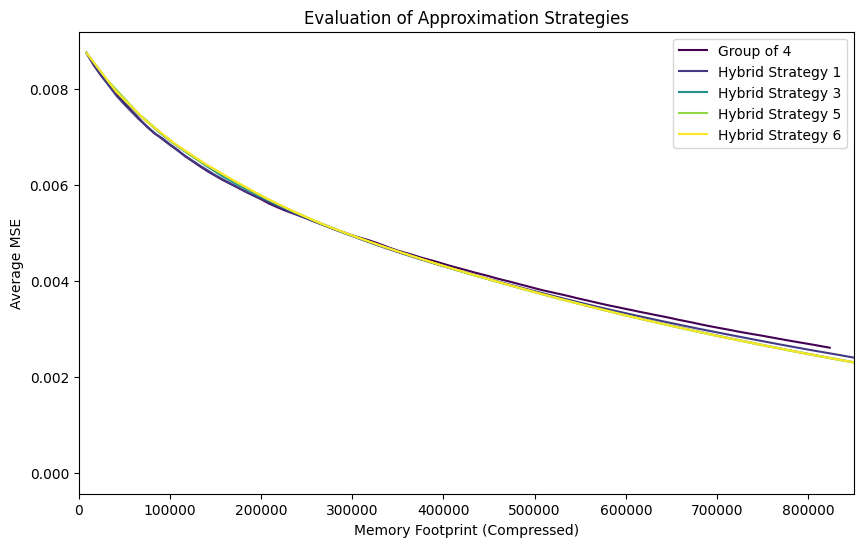

W1.num_group
[1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 1, 1, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 4, 4, 4, 2, 2, 3, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 4, 3, 3, 3, 2, 2, 1, 2, 1, 3, 3, 3, 2, 2, 3, 3, 4, 3, 3]
W3.num_group
[1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 2, 3, 4, 4, 4, 4, 3, 4, 4, 3, 2, 3, 2, 4, 3, 3, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1]
W5.num_group
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 2, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
W6.num_group
[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1,

In [23]:
evaluation1(weight_array)

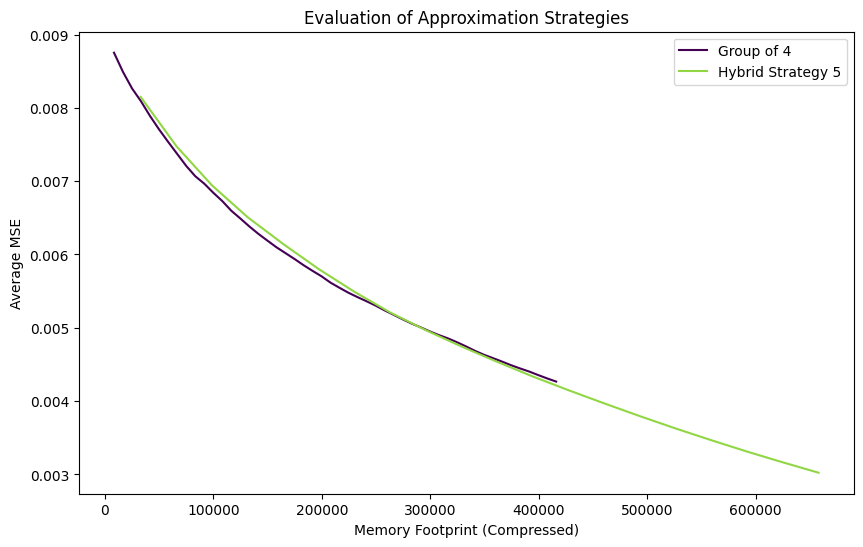

W5.num_group
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [54]:
evaluation1(weight_array)

In [64]:
def evaluation2(weight_array):

    MSE_list = [0.0035,0.00325,0.003,0.00275,0.0025,0.00225]

    W_baseline = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    W = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    W1 = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    # W2 = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    W3 = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    # W4 = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    W5 = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)
    W6 = WeightArrayStepPruning(weight_array,0.0001,64,192,1,1)

    # Initialize lists to store data points for plotting
    W_baseline_memory_footprints = []
    W_baseline_mses = []

    W_memory_footprints = []
    W_mses = []
    W1_memory_footprints = []
    W1_mses = []
    W3_memory_footprints = []
    W3_mses = []
    W5_memory_footprints = []
    W5_mses = []
    W6_memory_footprints = []
    W6_mses = []

    W_baseline_MSE = 0.01

    for MSE in MSE_list:
        while W_baseline_MSE > MSE:
            W_baseline.iterative_approximation_step1()
            W_baseline_MSE = W_baseline.average_mse()
        W_baseline_memory_footprints.append(W_baseline.memory_footprint_compressed)
        W_baseline_mses.append(W_baseline_MSE)

    W_MSE = 0.01

    for MSE in MSE_list:
        while W_MSE > MSE:
            W.iterative_approximation_step2()
            W_MSE = W.average_mse()
        W_memory_footprints.append(W.memory_footprint_compressed)
        W_mses.append(W_MSE)

    W1_MSE = 0.01

    for MSE in MSE_list:
        while W1_MSE > MSE:
            W1.hybrid_iterative_approximation_step(1)
            W1_MSE = W1.average_mse()
        W1_memory_footprints.append(W1.memory_footprint_compressed)
        W1_mses.append(W1_MSE)

    W3_MSE = 0.01

    for MSE in MSE_list:
        while W3_MSE > MSE:
            W3.hybrid_iterative_approximation_step(3)
            W3_MSE = W3.average_mse()
        W3_memory_footprints.append(W3.memory_footprint_compressed)
        W3_mses.append(W3_MSE)

    W5_MSE = 0.01

    for MSE in MSE_list:
        while W5_MSE > MSE:
            W5.hybrid_iterative_approximation_step(5)
            W5_MSE = W5.average_mse()
        W5_memory_footprints.append(W5.memory_footprint_compressed)
        W5_mses.append(W5_MSE)

    W6_MSE = 0.01
    for MSE in MSE_list:
        while W6_MSE > MSE:
            W6.hybrid_iterative_approximation_step(6)
            W6_MSE = W6.average_mse()
        W6_memory_footprints.append(W6.memory_footprint_compressed)
        W6_mses.append(W6_MSE)
    

    colors = plt.cm.viridis(np.linspace(0, 1, 7))  

    # Calculate percentage differences in memory footprints
    W_memory_footprints_percentage_diff = [(w - w1) / w * 100 for w, w1 in zip(W_baseline_memory_footprints, W_memory_footprints)]
    W1_memory_footprints_percentage_diff = [(w - w1) / w * 100 for w, w1 in zip(W_baseline_memory_footprints, W1_memory_footprints)]
    W3_memory_footprints_percentage_diff = [(w - w3) / w * 100 for w, w3 in zip(W_baseline_memory_footprints, W3_memory_footprints)]
    W5_memory_footprints_percentage_diff = [(w - w5) / w * 100 for w, w5 in zip(W_baseline_memory_footprints, W5_memory_footprints)]
    W6_memory_footprints_percentage_diff = [(w - w6) / w * 100 for w, w6 in zip(W_baseline_memory_footprints, W6_memory_footprints)]

    # Number of groups and bar width
    n_groups = len(MSE_list)
    bar_width = 0.1

    # Create the plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)

    # Plotting each configuration as a separate bar for each MSE
    bars0 = ax.bar(index - 2 * bar_width, W_memory_footprints_percentage_diff, bar_width, color=colors[0], label='Grouping of 4')
    bars1 = ax.bar(index - bar_width, W1_memory_footprints_percentage_diff, bar_width, color=colors[1], label='Hybrid Strategy 1')
    bars2 = ax.bar(index, W3_memory_footprints_percentage_diff, bar_width, color=colors[3], label='Hybrid Strategy 3')
    bars3 = ax.bar(index + bar_width, W5_memory_footprints_percentage_diff, bar_width, color=colors[5], label='Hybrid Strategy 5')
    bars4 = ax.bar(index + 2 * bar_width, W6_memory_footprints_percentage_diff, bar_width, color=colors[6], label='Hybrid Strategy 6')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('MSE Threshold')
    ax.set_ylabel('Memory Footprint Percentage Reduction (%)')
    ax.set_title('Memory Footprint Reduction for Different Strategies')
    ax.set_xticks(index + 1.5*bar_width)
    ax.set_xticklabels(MSE_list)
    ax.legend()

    plt.grid(True)  
    plt.show()

    print('W_baseline_memory_footprints')
    print(W_baseline_memory_footprints)
    print('W_memory_footprints')
    print(W_memory_footprints)
    print('W1_memory_footprints')
    print(W1_memory_footprints)
    print('W3_memory_footprints')
    print(W3_memory_footprints)
    print('W5_memory_footprints')
    print(W5_memory_footprints)
    print('W6_memory_footprints')
    print(W6_memory_footprints)

    

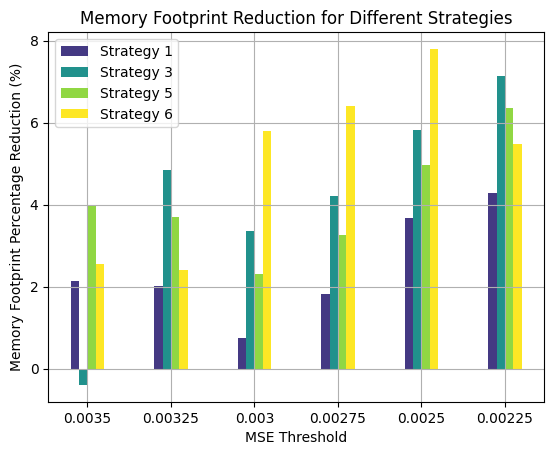

W_memory_footprints
[582400, 648960, 707200, 782080, 865280, 948480]
W1_memory_footprints
[569984, 635904, 701824, 767744, 833536, 907776]
W3_memory_footprints
[584704, 617600, 683392, 749184, 814976, 880768]
W5_memory_footprints
[559232, 625024, 690816, 756608, 822400, 888192]
W6_memory_footprints
[567552, 633344, 666240, 732032, 797824, 896512]


In [56]:
evaluation2(weight_array)

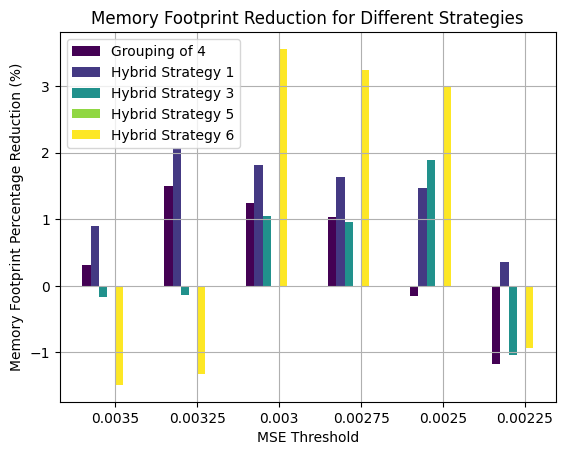

W_baseline_memory_footprints
[559232, 625024, 690816, 756608, 822400, 888192]
W_memory_footprints
[557440, 615680, 682240, 748800, 823680, 898560]
W1_memory_footprints
[554240, 612096, 678272, 744192, 810368, 884992]
W3_memory_footprints
[560128, 625920, 683520, 749312, 806912, 897408]
W5_memory_footprints
[559232, 625024, 690816, 756608, 822400, 888192]
W6_memory_footprints
[567552, 633344, 666240, 732032, 797824, 896512]


In [65]:
evaluation2(weight_array)

In [66]:
weight_array = [weight_array_left[0],weight_array_left[1],weight_array_left[2],weight_array_left[3]]

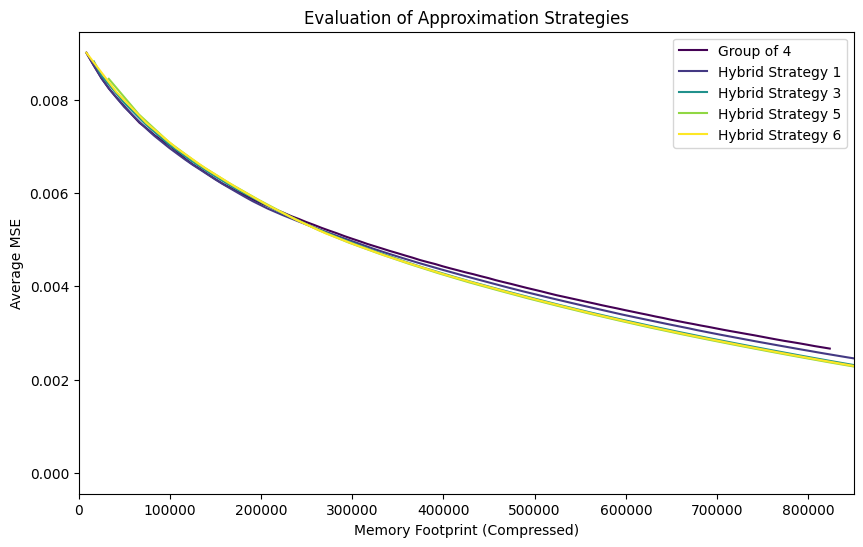

W1.num_group
[1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 1, 2, 1, 2, 2, 3, 3, 2, 2, 2, 2, 3, 1, 3, 4, 1, 3, 3, 1, 1, 1, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 1, 1, 1, 2, 1, 4, 3, 2]
W3.num_group
[2, 1, 3, 3, 3, 3, 3, 3, 4, 2, 3, 2, 3, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 2, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 2, 2, 4, 2, 3, 2, 1, 3, 3, 2, 2, 1, 2, 1, 1, 1, 1]
W5.num_group
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 2, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
W6.num_group
[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1,

In [29]:
evaluation1(weight_array)

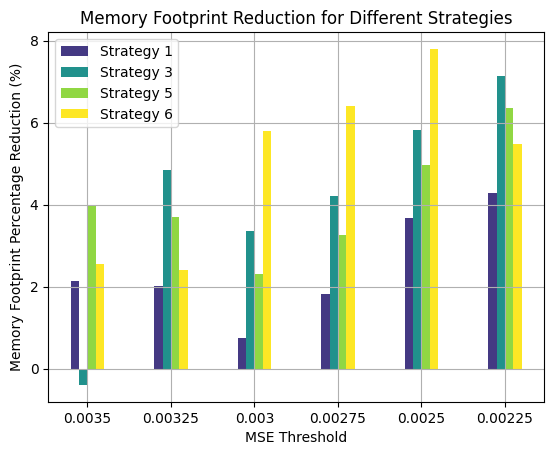

W_memory_footprints
[582400, 648960, 707200, 782080, 865280, 948480]
W1_memory_footprints
[569984, 635904, 701824, 767744, 833536, 907776]
W3_memory_footprints
[584704, 617600, 683392, 749184, 814976, 880768]
W5_memory_footprints
[559232, 625024, 690816, 756608, 822400, 888192]
W6_memory_footprints
[567552, 633344, 666240, 732032, 797824, 896512]


In [57]:
evaluation2(weight_array) # baseline is group of 4

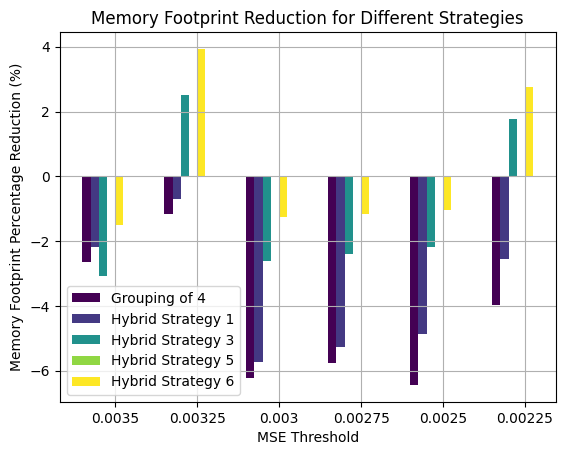

W_baseline_memory_footprints
[559232, 625024, 657920, 723712, 789504, 888192]
W_memory_footprints
[574080, 632320, 698880, 765440, 840320, 923520]
W1_memory_footprints
[571392, 629376, 695552, 761856, 828032, 910720]
W3_memory_footprints
[576512, 609408, 675200, 740992, 806784, 872576]
W5_memory_footprints
[559232, 625024, 657920, 723712, 789504, 888192]
W6_memory_footprints
[567552, 600448, 666240, 732032, 797824, 863616]


In [67]:
evaluation2(weight_array) # baseline is group of 1

In [17]:
def extract_weight_array(layer):
    kernel, recurrent_kernel, bias = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [18]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel,original_layer[2]]
    
    layer.set_weights(approximated_weight)


In [31]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


0.8713

In [159]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# mse = np.linspace(0.004, 0.002, 3)
# MSE_list = mse.tolist()
MSE_list = [0.0035,0.00325,0.003,0.00275,0.0025,0.00225]

# cross cell: input and forgot gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
# cross cell: ouput and cell gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_left_weight_array[0],LSTM_left_weight_array[1]]
WW = [LSTM_right_weight_array[2],LSTM_right_weight_array[3],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step1()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step1()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W1_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]

    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

# method2: group 4 approximation  
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)


# method3: stack matrix approximation  

W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W1_MSE = mean_square_error_array1(W,W1_approximated)
        W2_approximated = W2.iterative_approximation_step3()
        W2_MSE = mean_square_error_array1(WW,W2_approximated)
        W_MSE = (W1_MSE + W2_MSE)/2

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)


# method4: hybrid approximation strategy 1
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(1)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result4.append(accuracy)

# method4: hybrid approximation strategy 3
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W5_memory_footprints = []
W5_mses = []

W_MSE = 0.01

accuracy_result5 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(3)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(3)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W5_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W5_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result5.append(accuracy)

# method4: hybrid approximation strategy 5
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(5)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result6.append(accuracy)

# method4: hybrid approximation strategy 6
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(6)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result7.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14

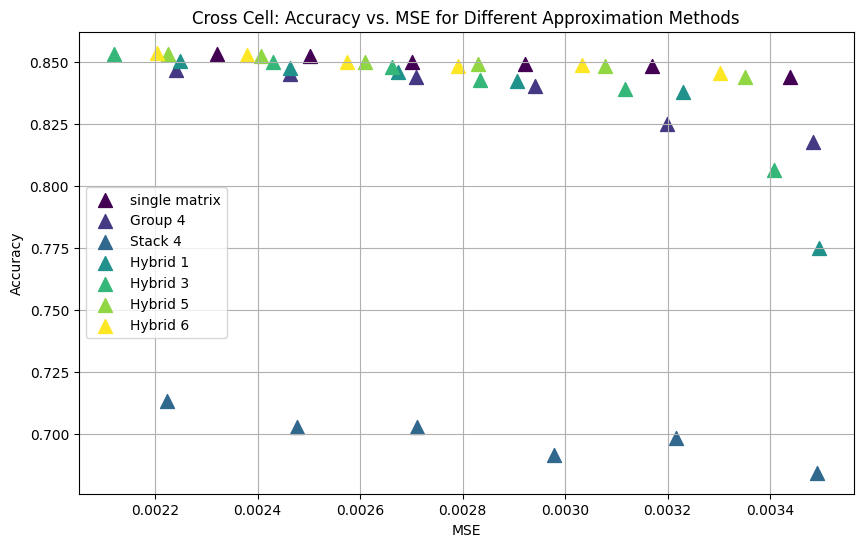

In [162]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W5_mses, W6_mses, W7_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3, accuracy_result4, accuracy_result5, accuracy_result6, accuracy_result7]
label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 3','Hybrid 5','Hybrid 6']
# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Cell: Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.grid(True)
plt.show()

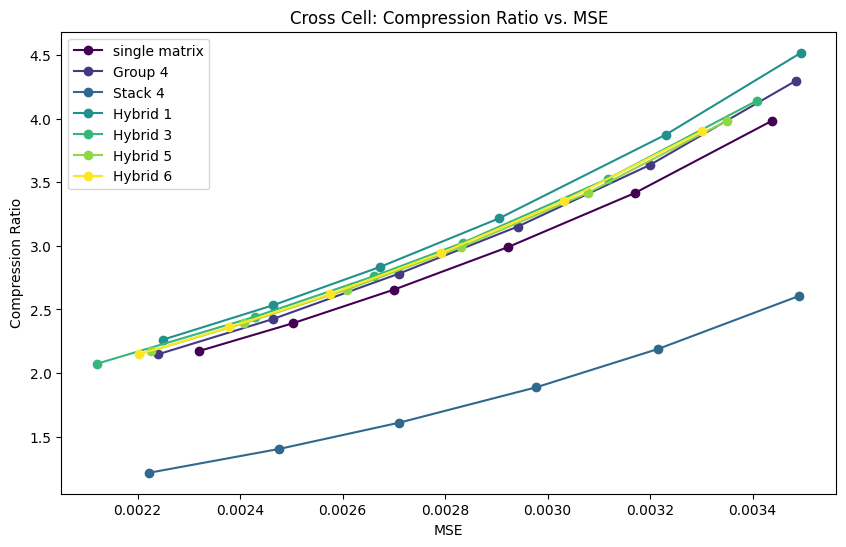

In [163]:
# Baseline memory footprint
baseline_mem_footprint = 1572864

label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 3','Hybrid 5','Hybrid 6']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W3_memory_footprints]
normalized_W4_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]
normalized_W5_mem_footprints = [baseline_mem_footprint/x for x in W5_memory_footprints]
normalized_W6_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W7_mem_footprints = [baseline_mem_footprint/x for x in W7_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints, normalized_W4_mem_footprints, normalized_W5_mem_footprints, normalized_W6_mem_footprints, normalized_W7_mem_footprints]
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W5_mses, W6_mses, W7_mses]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Cell: Compression Ratio vs. MSE')
plt.legend()
plt.show()

In [177]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# mse = np.linspace(0.004, 0.002, 3)
# MSE_list = mse.tolist()
MSE_list = [0.0035,0.00325,0.003,0.00275,0.0025,0.00225]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step1()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step1()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W1_MSE)


    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

# method2: group 4 approximation  
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)


# method3: stack matrix approximation  
W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W1_MSE = mean_square_error_array1(W,W1_approximated)
        W2_approximated = W2.iterative_approximation_step3()
        W2_MSE = mean_square_error_array1(WW,W2_approximated)
        W_MSE = (W1_MSE + W2_MSE)/2

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)


# method4: hybrid approximation strategy 1
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(1)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result4.append(accuracy)

# method4: hybrid approximation strategy 3
# W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
# W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
# W5_memory_footprints = []
# W5_mses = []

# W_MSE = 0.01

# accuracy_result5 = []

# for MSE in MSE_list:
#     while W_MSE > MSE:
#         W1.hybrid_iterative_approximation_step(3)
#         W1_MSE = W1.average_mse()
#         W2.hybrid_iterative_approximation_step(3)
#         W2_MSE = W2.average_mse()
#         W_MSE = (W1_MSE + W2_MSE)/2

#     W1_approximated = W1.current_reconstructed_weight_array
#     W2_approximated = W2.current_reconstructed_weight_array

#     W5_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
#     W5_mses.append(W_MSE)

#     set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
#     set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

#     predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
#     accuracy = accuracy_score(fashion_test_labels, predicted_classes)

#     accuracy_result5.append(accuracy)

# method4: hybrid approximation strategy 5
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(5)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result6.append(accuracy)

# method4: hybrid approximation strategy 6
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(6)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result7.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 393ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s

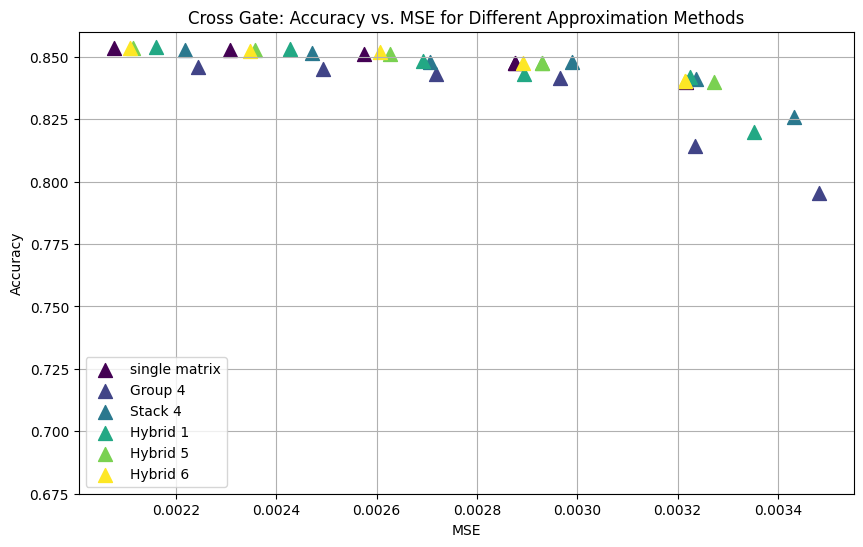

In [187]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W6_mses, W7_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3, accuracy_result4, accuracy_result6, accuracy_result7]
label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 5','Hybrid 6']
# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.ylim([0.675,0.86])
plt.grid(True)
plt.show()

In [34]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.0045,0.00425,0.004,0.00375,0.0035,0.00325,0.003,0.00275,0.0025,0.00225]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W1_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Group 4 with Frobenius norm
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('fro')
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step2_norm('fro')
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)

# Group 4 with spectral norm
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('spec')
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step2_norm('spec')
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14

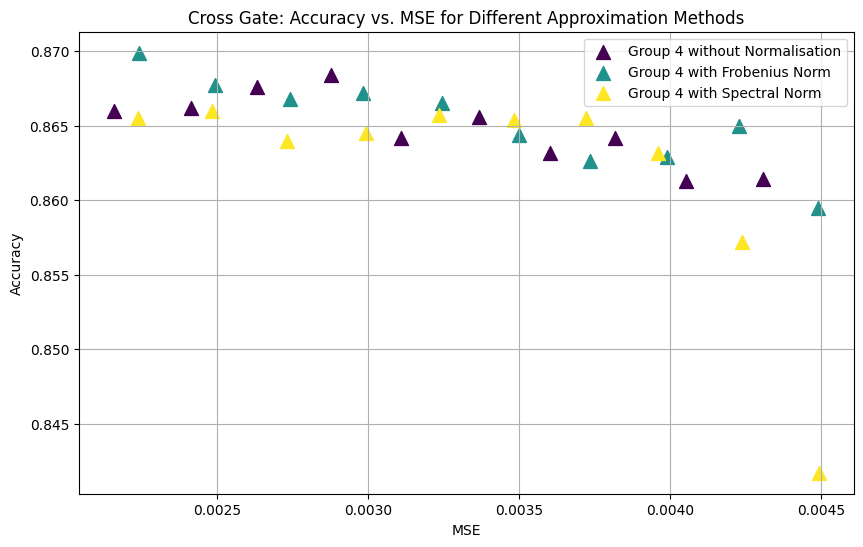

In [35]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3]
label_list = ['Group 4 without Normalisation','Group 4 with Frobenius Norm','Group 4 with Spectral Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.grid(True)
plt.show()

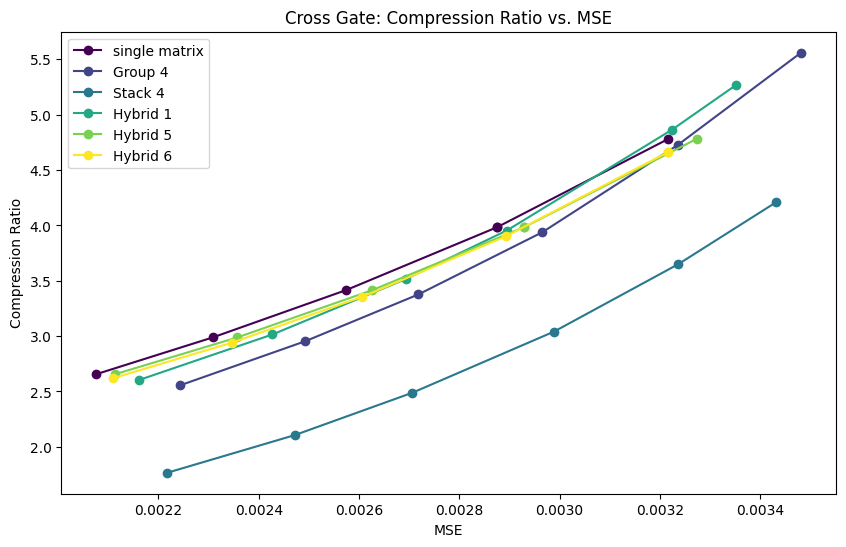

In [180]:
# Baseline memory footprint
baseline_mem_footprint = 1572864

label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 5','Hybrid 6']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W3_memory_footprints]
normalized_W4_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]
# normalized_W5_mem_footprints = [baseline_mem_footprint/x for x in W5_memory_footprints]
normalized_W6_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W7_mem_footprints = [baseline_mem_footprint/x for x in W7_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints, normalized_W4_mem_footprints, normalized_W6_mem_footprints, normalized_W7_mem_footprints]
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W6_mses, W7_mses]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend()

plt.show()

In [ ]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# cross cell: input and forgot gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
# cross cell: ouput and cell gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_left_weight_array[0],LSTM_left_weight_array[1]]
WW = [LSTM_right_weight_array[2],LSTM_right_weight_array[3],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# method1: single matrix approximation
MSE = 0.0028

W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W_MSE = 0.01

accuracy_result1 = []

while W_MSE > MSE:
    W1.iterative_approximation_step1()
    W1_MSE = W1.average_mse()
    W2.iterative_approximation_step1()
    W2_MSE = W2.average_mse()
    W_MSE = (W1_MSE + W2_MSE)/2

W1_approximated = W1.current_reconstructed_weight_array
W2_approximated = W2.current_reconstructed_weight_array

W1_memory_footprints = (W1.memory_footprint_compressed+W2.memory_footprint_compressed)
W1_mses = W_MSE
W1_num_group = W1.num_group

right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy_result1 = accuracy_score(fashion_test_labels, predicted_classes)


In [227]:
import math
def generate_pairs(R):
    # Define the possible values for Tc
    Tc_values = [2, 4, 8, 10, 16, 32, 64]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = R // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [10, 16, 32, 64]:
                valid_pairs.append([Tc, NZc])


    # Return the list of valid pairs
    return valid_pairs

# Example usage
R = 64
valid_pairs_R = generate_pairs(R)
print(valid_pairs_R)

[[2, 16], [2, 24], [2, 32], [4, 8], [4, 12], [4, 16], [8, 4], [8, 6], [8, 8], [10, 3], [10, 4], [10, 5], [10, 6], [16, 2], [16, 3], [16, 4], [32, 1], [32, 2], [64, 1]]


In [228]:
def generate_pairs2(C):
    # Define the possible values for Tc
    Tc_values = [2, 8, 16, 32, 64, 192]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = C // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 16 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64, 192]:
                valid_pairs.append([Tc, NZc])

    # Return the list of valid pairs
    return valid_pairs

# Example usage
C = 192
valid_pairs_C = generate_pairs2(C)
print(valid_pairs_C)

[[2, 48], [2, 64], [2, 80], [2, 96], [8, 12], [8, 16], [8, 20], [8, 24], [16, 6], [16, 7], [16, 8], [16, 9], [16, 10], [16, 11], [16, 12], [32, 3], [32, 4], [32, 5], [32, 6], [64, 2], [64, 3], [192, 1]]


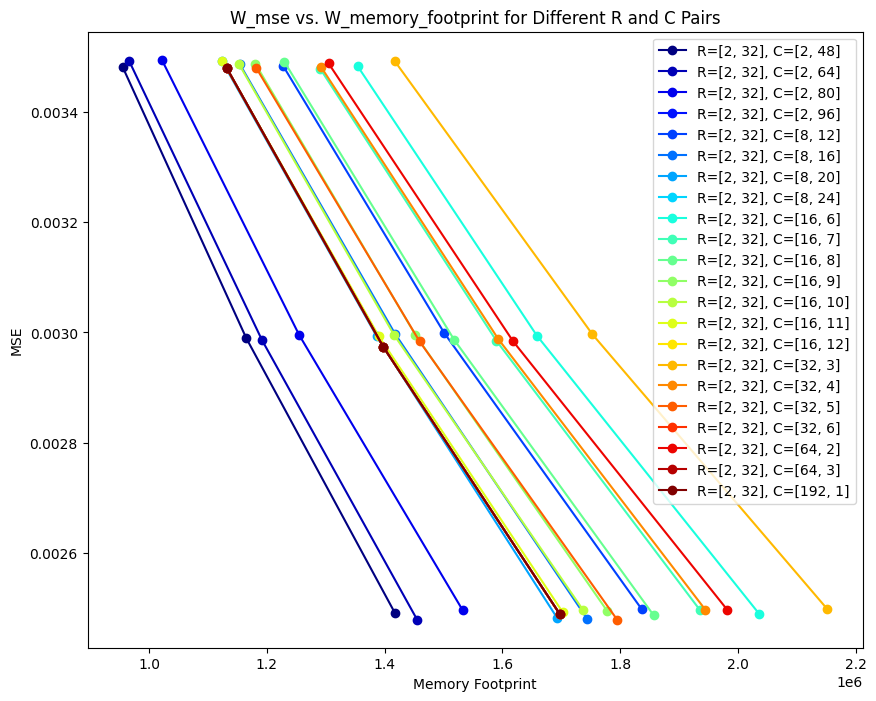

In [236]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# Generate a color map to differentiate the pair_R and pair_C combinations
colors = plt.cm.jet(np.linspace(0, 1, len(valid_pairs_R[2:3]) * len(valid_pairs_C)))

color_index = 0

plt.figure(figsize=(10, 8))

for pair_R in valid_pairs_R[2:3]:
    for pair_C in valid_pairs_C:
        # Initialize W1 and W2 with the pruning parameters
        W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
        W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

        W_MSE = 0.01
        MSE_list = [0.0035, 0.003, 0.0025]

        W_mses = []
        W_memory_footprint = []

        # Iterate through MSE targets
        for MSE in MSE_list:
            while W_MSE > MSE:
                W1.iterative_approximation_step2()
                W1_MSE = W1.average_mse()
                W2.iterative_approximation_step2()
                W2_MSE = W2.average_mse()
                W_MSE = (W1_MSE + W2_MSE) / 2

            W_mses.append(W_MSE)
            W_memory_footprint.append(W1.memory_footprint_compressed + W2.memory_footprint_compressed)

        # Plot the results with the corresponding color
        plt.plot(W_memory_footprint, W_mses, marker='o', color=colors[color_index], label=f'R={pair_R}, C={pair_C}')
        color_index += 1

plt.xlabel('Memory Footprint')
plt.ylabel('MSE')
plt.title('W_mse vs. W_memory_footprint for Different R and C Pairs')
plt.legend()
plt.show()

        